In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import  DatasetDriftMetric, DatasetMissingValuesMetric, DatasetSummaryMetric
from evidently.metrics import ColumnDriftMetric, RegressionQualityMetric, ColumnQuantileMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

c:\Users\Dell\miniconda3\envs\ml-env\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Dell\miniconda3\envs\ml-env\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\Dell\miniconda3\envs\ml-env\lib\site-packages\umap\distances.py:1086: NumbaDepr

In [2]:
files = [('green_tripdata_2023-01.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"{file}",
                        postfix=f"save to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


green_tripdata_2023-01.parquet: 100%|██████████| 1427002/1427002 [00:07<00:00, 193902.90it/s, save to ./data/green_tripdata_2023-01.parquet]


In [3]:
df = pd.read_parquet('./data/green_tripdata_2023-03.parquet')
df.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,72044.000000,72044,72044,67507.000000,72044.000000,72044.000000,67507.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,0.0,72044.000000,72044.000000,67507.000000,67500.000000,67507.000000
mean,1.865443,2023-03-16 08:02:42.689842432,2023-03-16 08:20:56.525747968,1.145703,98.437413,137.613556,1.286844,12.449511,17.018203,0.878109,0.576929,2.157651,0.183268,NaN,0.961604,22.292310,1.373680,1.028681,0.714837
min,1.000000,2023-02-23 16:46:29,2023-02-23 16:55:25,1.000000,1.000000,1.000000,0.000000,0.000000,-115.000000,-5.000000,-0.500000,-1.100000,0.000000,NaN,-1.000000,-116.000000,1.000000,1.000000,-2.750000
25%,2.000000,2023-03-08 13:55:49.500000,2023-03-08 14:15:59.750000128,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.980000,1.000000,1.000000,0.000000
50%,2.000000,2023-03-16 08:05:27.500000,2023-03-16 08:22:27,1.000000,75.000000,138.000000,1.000000,1.840000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,18.100000,1.000000,1.000000,0.000000
75%,2.000000,2023-03-23 21:51:25.500000,2023-03-23 22:12:31.500000,1.000000,129.000000,216.000000,1.000000,3.300000,20.000000,1.000000,0.500000,3.360000,0.000000,NaN,1.000000,26.730000,2.000000,1.000000,2.750000
max,2.000000,2023-04-01 00:09:27,2023-04-01 17:32:21,99.000000,265.000000,265.000000,9.000000,92064.680000,477.000000,12.500000,4.250000,270.270000,36.050000,NaN,1.000000,478.000000,5.000000,2.000000,2.750000
std,0.341252,NaN,NaN,1.225735,60.481870,76.169705,0.923652,641.094653,13.832399,1.297642,0.384129,3.136215,1.139159,NaN,0.185185,15.852047,0.512307,0.166911,1.206435


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72044 entries, 0 to 72043
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               72044 non-null  int32         
 1   lpep_pickup_datetime   72044 non-null  datetime64[ns]
 2   lpep_dropoff_datetime  72044 non-null  datetime64[ns]
 3   store_and_fwd_flag     67507 non-null  object        
 4   RatecodeID             67507 non-null  float64       
 5   PULocationID           72044 non-null  int32         
 6   DOLocationID           72044 non-null  int32         
 7   passenger_count        67507 non-null  float64       
 8   trip_distance          72044 non-null  float64       
 9   fare_amount            72044 non-null  float64       
 10  extra                  72044 non-null  float64       
 11  mta_tax                72044 non-null  float64       
 12  tip_amount             72044 non-null  float64       
 13  t

In [5]:
# prepare data
df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df["duration"] = df["duration"].apply(lambda x: x.total_seconds() / 60)

In [6]:
df.duration.describe()

count    72044.000000
mean        18.230598
std         70.272133
min          0.000000
25%          7.300000
50%         11.600000
75%         18.033333
max       1438.466667
Name: duration, dtype: float64

In [7]:
# filter the outliers
df = df[(df.duration >= 0) & (df.duration <= 60)]
df = df[(df.passenger_count > 0) & (df.passenger_count <= 8)]

In [8]:
df.duration.describe()

count    66255.000000
mean        13.383636
std          9.342822
min          0.000000
25%          7.100000
50%         11.183333
75%         17.050000
max         60.000000
Name: duration, dtype: float64

<Axes: >

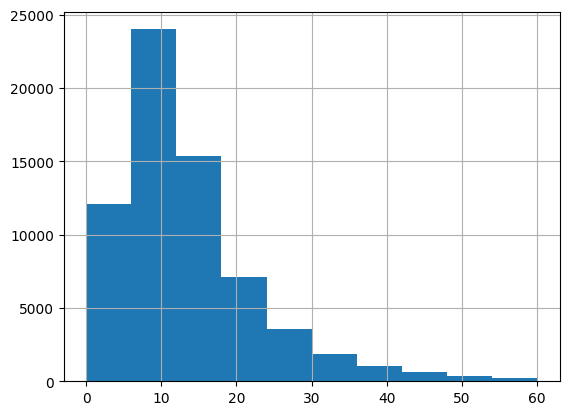

In [9]:
df.duration.hist()

In [10]:
# data labeling
target = "duration"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [11]:
df.shape

(66255, 21)

In [11]:
train_data = df[:40000]
val_data = df[40000:]

In [12]:
model = LinearRegression()
model.fit(train_data[num_features+ cat_features], train_data[target])

LinearRegression()

In [13]:
train_preds = model.predict(train_data[num_features+cat_features])

In [14]:
train_data["prediction"] = train_preds

In [15]:
train_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,prediction
0,2,2023-03-01 00:25:10,2023-03-01 00:35:47,N,1.0,82,196,1.0,2.36,13.5,...,0.00,0.0,NaN,1.0,16.00,2.0,1.0,0.00,10.616667,12.418828
1,2,2023-03-01 00:14:29,2023-03-01 00:25:04,N,1.0,7,7,1.0,0.78,-6.5,...,0.00,0.0,NaN,-1.0,-9.00,3.0,1.0,0.00,10.583333,1.881913
2,2,2023-03-01 00:14:29,2023-03-01 00:25:04,N,1.0,7,7,1.0,0.78,6.5,...,0.00,0.0,NaN,1.0,9.00,3.0,1.0,0.00,10.583333,7.603453
3,2,2023-02-28 22:59:46,2023-02-28 23:08:38,N,1.0,166,74,1.0,1.66,11.4,...,2.78,0.0,NaN,1.0,16.68,1.0,1.0,0.00,8.866667,10.109842
4,2,2023-03-01 00:54:03,2023-03-01 01:03:14,N,1.0,236,229,1.0,3.14,15.6,...,4.17,0.0,NaN,1.0,25.02,1.0,1.0,2.75,9.183333,13.604295


In [16]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [17]:
val_data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration,prediction
40759,2,2023-03-19 06:18:10,2023-03-19 07:01:31,N,1.0,95,140,1.0,12.46,55.5,...,0.00,0.0,NaN,1.0,59.75,2.0,1.0,2.75,43.350000,39.788288
40760,2,2023-03-19 06:12:59,2023-03-19 06:45:34,N,1.0,75,25,1.0,10.58,48.5,...,5.28,0.0,NaN,1.0,58.03,1.0,1.0,2.75,32.583333,34.800909
40761,2,2023-03-19 07:48:13,2023-03-19 07:54:36,N,1.0,41,42,1.0,1.33,9.3,...,2.70,0.0,NaN,1.0,13.50,1.0,1.0,0.00,6.383333,9.327326
40762,2,2023-03-19 06:57:54,2023-03-19 07:11:31,N,1.0,263,161,1.0,3.46,17.7,...,8.25,0.0,NaN,1.0,30.20,1.0,1.0,2.75,13.616667,14.513201
40763,2,2023-03-19 06:06:25,2023-03-19 06:38:53,N,1.0,66,75,1.0,8.16,39.4,...,0.00,0.0,NaN,1.0,43.65,2.0,1.0,2.75,32.466667,28.720321


In [18]:
print(mean_absolute_error(train_data.duration, train_data.prediction))
print(mean_absolute_error(val_data.duration, val_data.prediction))

3.632884615912544
3.5561231068594488


In [21]:
# Dump the model and reference data
with open('./models/lin_reg.bin', 'wb') as f:
    dump(model, f)


In [20]:
val_data.to_parquet("./data/reference_data.parquet")

### Evidently Report

In [23]:
column_mapping = ColumnMapping(
    target= 'duration',
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [46]:
report = Report(metrics=[
    DatasetDriftMetric(),
    DatasetMissingValuesMetric(),
    ColumnDriftMetric(column_name='prediction'),
    RegressionQualityMetric(),
    ColumnQuantileMetric(column_name='fare_amount', quantile=0.5)
]
)

In [47]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [58]:
#report.show(mode='inline')

In [49]:
result = report.as_dict()

In [50]:
result

{'metrics': [{'metric': 'DatasetDriftMetric',
   'result': {'drift_share': 0.5,
    'number_of_columns': 8,
    'number_of_drifted_columns': 0,
    'share_of_drifted_columns': 0.0,
    'dataset_drift': False}},
  {'metric': 'DatasetMissingValuesMetric',
   'result': {'current': {'different_missing_values': {'': 0,
      -inf: 0,
      None: 26257,
      inf: 0},
     'number_of_different_missing_values': 1,
     'different_missing_values_by_column': {'VendorID': {'': 0,
       -inf: 0,
       None: 0,
       inf: 0},
      'lpep_pickup_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
      'lpep_dropoff_datetime': {'': 0, -inf: 0, None: 0, inf: 0},
      'store_and_fwd_flag': {'': 0, -inf: 0, None: 0, inf: 0},
      'RatecodeID': {'': 0, -inf: 0, None: 0, inf: 0},
      'PULocationID': {'': 0, -inf: 0, None: 0, inf: 0},
      'DOLocationID': {'': 0, -inf: 0, None: 0, inf: 0},
      'passenger_count': {'': 0, -inf: 0, None: 0, inf: 0},
      'trip_distance': {'': 0, -inf: 0, None: 0, inf: 

In [51]:
#number of drifted columns
result['metrics'][0]['result']['number_of_drifted_columns']

0

In [53]:
#share of missing values
result['metrics'][1]['result']['current']['share_of_missing_values']

0.045458007998476484

In [54]:
#prediction drift
result['metrics'][2]['result']['drift_score']

0.01267314387651645

In [59]:
# MAE
result['metrics'][3]['result']['current']['mean_abs_error']

3.5561231068594488

In [56]:
# fare amount quantile
result['metrics'][4]['result']['current']['value']

12.8